# 시간과 파이토치의 방
### 파이토치 씹어먹기
* 참고: https://tutorials.pytorch.kr/beginner/basics/intro.html

## 2. DATASET과 DATALOADER

* 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있음.
    * 더 나은 가독성과 모듈성을 위해, 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적
    
    
* PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공하여 미리 준비된 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 함
    * Dataset은 샘플과 정답(label)을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다

### 데이터셋 불러오기

* TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제
    * 60,000개의 학습 데이터와 10,000 데스트 데이터로 이루어져 있음
    * 28 X 28 사이즈의 이미지와 10개의 class 중 하나인 정답(label)로 구성

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 데이터셋을 순회하고 시각화하기
* Dataset에 list처럼 직접 접근이 가능

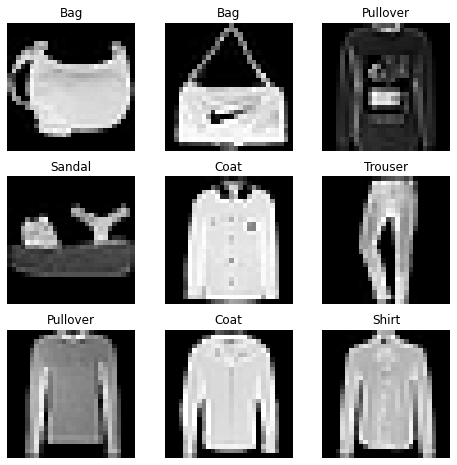

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

### 파일에서 사용자 정의 데이터셋 만들기
* 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함
    * \_\_init\_\_: Dataset 객체가 생성될 때 한 번만 실행. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두 가지 변형(transform)을 초기화
    
    * \_\_len\_\_: Dataset의 sample 갯수를 반환
    
    * \_\_getitem\_\_: 주어진 인덱스 idx에 해당하는 sample을 Dataset에서 불러오고 반환. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 변환하고, self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, tensor 이미지와 label을 Python 딕셔너리형으로 반환

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitme__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### DataLoader로 학습용 데이터 준비하기
* Dataset의 특징(feature)을 가져오고 하나의 sample에 정답(label)을 지정하는 일을 한 번에 수행
* 모델을 학습할 때, 일반적으로 sample들을 minibatch로 전달하고 매 epoch마다 데이터를 다시 섞어서 overfitting을 막고, Python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 함
* DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기(iterate)
* DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있음
* 다음의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환
* shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞임

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


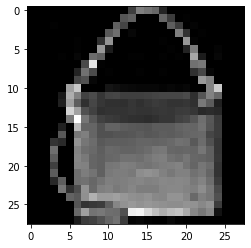

Label: 8


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")